# ctreating the dataset
## first step (creating aditional parset to find product names in own catalog)

- find all links in home page (that have list of subcatalog and all products)

In [2]:
import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup

def get_all_links(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # check errors
        
        soup = BeautifulSoup(response.text, 'html.parser')
        links = []
        for link in soup.find_all('a', href=True):
            href = link['href']
            absolute_url = urljoin(url, href)
            
            # Фильтруем якорные ссылки (например, #section)
            if not absolute_url.startswith('#'):
                links.append(absolute_url)

        return list(set(links)) 
    
    except requests.RequestException as e:
        print(f"Ошибка при загрузке страницы: {e}")
        return []


if __name__ == "__main__":
    url = "https://mollanbros.co.uk" 
    all_links = get_all_links(url)
    
    # save to file
    with open("links.txt", "w") as f:
        f.write("\n".join(all_links))
    print("\nВсе ссылки сохранены в файл links.txt")


Все ссылки сохранены в файл links.txt


after the parsing delete some links, that doesn`t relate with this catalog

```
examples
https://www.nopcommerce.com/
https://mollanbros.co.uk/register?returnUrl=%2F
```

### remark

In many catalogs, tags containing product names share the same **class name**.
This provides an opportunity to efficiently locate all products by searching for these links.

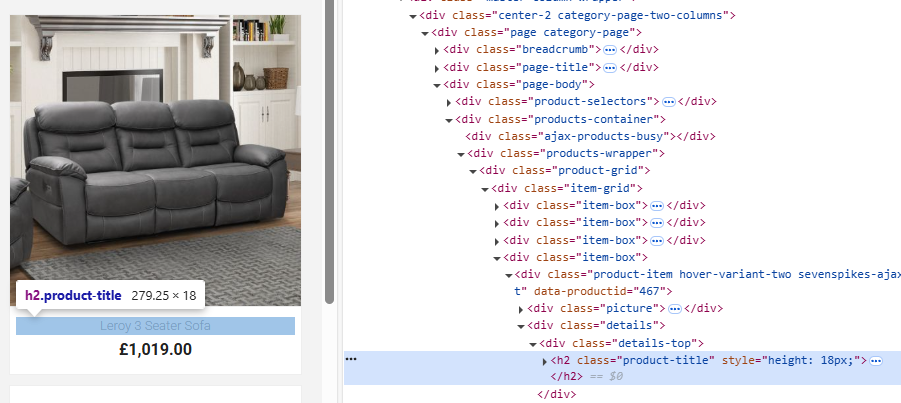

### ⚠ Important Note:
If you want to parse a different catalog, you must either:
- Update the class name in the code, or
- Modify the search structure to match the new catalog’s HTML layout.

In [4]:
import pandas as pd
from urllib.parse import urlparse
import requests
from bs4 import BeautifulSoup


def is_valid_url(url):
    """Проверяет, является ли URL валидным."""
    parsed = urlparse(url)
    return bool(parsed.scheme) and bool(parsed.netloc)

# variant of anither aditional parser
""" 
def extract_product_titles(soup):
    product_titles = []
    for link in soup.find_all('p', class_="product-item__title"):
        title = ' '.join(link.get_text(strip=True).split())
        product_titles.append(title)
    return ', '.join(product_titles) if product_titles else ''
"""

def extract_product_titles(soup):
    product_titles = []

    # in h2
    for sp in soup.find_all('h2', class_="product-title"):
        title = ' '.join(sp.get_text(strip=True).split())
        product_titles.append(title)
    
    return ', '.join(product_titles) if product_titles else ''

def parser(url):
    try:
        response = requests.get(url, headers=headers, timeout=5)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        return {'product_titles': extract_product_titles(soup)}
    
    except Exception as e:
        print(f"Ошибка при обработке {url}: {e}")
        return {'product_titles': ''}

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept-Language': 'en-US,en;q=0.9',
    'Referer': 'https://www.google.com/',
    'Accept-Encoding': 'identity'  
}

if __name__ == "__main__":
    data = pd.read_csv('links.csv') 
    results = []

    for count, url in enumerate(data['URL'], 1):
        if is_valid_url(url):
            # print(f"Обработка URL {count}: {url}")
            parsed_data = parser(url)
            if parsed_data == '': continue
            results.append({
                'URL': url, 'Informative_Text': parsed_data['product_titles']
            })

    # save to csv
    result_df = pd.DataFrame(results)
    result_df.dropna()
    result_df.to_csv("extracted_data.csv", index=False)
    print("Данные успешно сохранены в extracted_data.csv")

Ошибка при обработке https://www.nopcommerce.com/: 403 Client Error: Forbidden for url: https://www.nopcommerce.com/
Данные успешно сохранены в extracted_data.csv


## Second Step (Create clean_parser that reduces all HTML page content but keeps targets)

### Why Clean the Data?
- Because NER (Named Entity Recognition) models cannot learn effectively from large text chunks:
- Memory Difficulties → Processing long texts requires excessive RAM/GPU memory
- Poor Results → Large contexts dilute the model's ability to recognize entities accurately

Key Requirements:
- Many tags containing **product names** have class names containing "...product..."
- Links to the product's own page and their child elements should be considered as **product names**
- **Product names** are written with capital letters (at the beginning)
- **Product names** do not consist of a single word and do not exceed 15 words
- **Product names** do not contain these special characters: `{'$', '?', '!', '.', '€', '%', '*', '+', '=', '\\'}`

In [ ]:
from bs4 import NavigableString, Tag
banned_symbols = {'$', '?', '!', '.', '€', '%', '*', '+', '=', '\\'}


def get_text_limited_depth(element, max_depth=2):
    texts = []

    def recurse(node, depth):
        if depth > max_depth:
            return
        if isinstance(node, NavigableString):
            text = str(node).strip()
            if text:
                texts.append(text)
        elif isinstance(node, Tag):
            for child in node.children:
                recurse(child, depth + 1)

    recurse(element, depth=0)
    return ' '.join(texts) if texts else ''


def check_and_add(tags_set, text): 
    if not text or not any(c.isalpha() for c in text):
        return
    
    words = text.split()
    if (2 <= len(words) <= 15 and
        not any(sym in text for sym in banned_symbols) and
        text[0].isupper()):  
        clean_text = ' '.join(words) # norm
        tags_set.add(clean_text)


def extract_informative_text(soup):
    main_content = soup.find('main') or soup
    tags = set()
    
    # delete unusfule tags
    for element in main_content(['script', 'style', 'meta', 'noscript', 'link']):
        element.decompose()

    # 1. tags with PRODUCT
    product_classes = ['product', 'item', 'goods', 'card'] 
    for pattern in product_classes:
        for element in main_content.select(f"[class*={pattern}]"):
            text = get_text_limited_depth(element, max_depth=3)
            check_and_add(tags, text)

    # 2. Links <a>
    for link in main_content.find_all('a', href=True):    
        text = get_text_limited_depth(link, max_depth=2)
        check_and_add(tags, text)

    # 3. <h1 h2 h3 h4 .. h6>
    for header in main_content.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'strong', 'b']):
        text = get_text_limited_depth(header, max_depth=2)
        check_and_add(tags, text)
    
    return '. '.join(tags) if tags else ""

## Third Step (Merge and Create Dataset)

In [6]:
import pandas as pd


data = pd.read_csv('dataset_result.csv')
data.info()

print("\nПервые 10 строк:")
print(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   URL               605 non-null    object
 1   Informative_Text  605 non-null    object
 2   Texts             605 non-null    object
dtypes: object(3)
memory usage: 14.3+ KB

Первые 10 строк:
                                                 URL  \
0  http://www.muuduufurniture.com/products/frame-...   
1            https://24estyle.com/products/eliza-fan   
2  https://allwoodfurn.com/products/group-119-rus...   
3    https://americanbackyard.com/products/gift-card   
4       https://asplundstore.se/products/fish-bricka   
5   https://barnabylane.com.au/products/spensley-tan   
6  https://big-sale-furniture.com/products/amster...   
7  https://candb.ca/products/10-gel-memory-foam-m...   
8  https://classicwithatwist.com.au/products/1900...   
9  https://craftassociatesfurniture.com/product